# Customer Intent Classification and Response Prioritization

**Objective**:  
Classify customer tweets into intents (`complaint`, `inquiry`, `praise`, `cancellation`) using T5-Small with refined few-shot prompting, validate on a ground-truth subset, and assign priority scores for call center routing.

*Prioritizes cancellation, complaint, and praise over inquiries, reclassifying negative sentiment inquiries as complaints to reduce skew.*

## **Inputs**:
- `../data/processed/sentiment_twcs.csv`: ~1.26M rows with `customer_text`, `cleaned_text`, `sentiment_label`, `churn_label`.

## **Instructions**:
1. Ensure `../data/processed/sentiment_twcs.csv` exists.
2. Install dependencies:  
   `pip install pandas numpy matplotlib seaborn transformers tqdm`
3. Run in a Jupyter Notebook. ~2–3 minutes on CPU for ~365 rows.
4. Review outputs in `../figures/` and `../data/processed/` for portfolio use.


## 1. Environment Setup

*Import required libraries and suppress warnings for clean output.*


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import re
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✅ Environment ready.")

✅ Environment ready.


## 2. Load Data

*Load the processed TWCS dataset, apply keyword-based pre-filtering for balanced intent sampling, and reclassify negative sentiment inquiries as complaints.*


In [27]:
try:
    df = pd.read_csv('../data/processed/sentiment_twcs.csv', encoding='utf-8')
    print("✅ TWCS loaded. Shape:", df.shape)
    print(df[['customer_text', 'cleaned_text', 'sentiment_label', 'churn_label']].head())
except FileNotFoundError:
    print("❌ Error: ../data/processed/sentiment_twcs.csv not found. Ensure Notebook 4 ran.")
    raise

df['cleaned_text'] = df['cleaned_text'].fillna('').astype(str)
print("✅ Cleaned_text prepared.")


✅ TWCS loaded. Shape: (1261888, 22)
                                       customer_text  \
0  @sprintcare I have sent several private messag...   
1                                 @sprintcare I did.   
2          @sprintcare is the worst customer service   
3  @sprintcare You gonna magically change your co...   
4  @sprintcare Since I signed up with you....Sinc...   

                                        cleaned_text sentiment_label  \
0  i understand i would like to assist you we wou...        POSITIVE   
1  please send us a private message so that we ca...        POSITIVE   
2  can you please send us a private message so th...        POSITIVE   
3  this is saddening to hear please shoot us a dm...        NEGATIVE   
4  we understand your concerns and wed like for y...        POSITIVE   

   churn_label  
0            0  
1            0  
2            0  
3            0  
4            0  
✅ Cleaned_text prepared.


## Keyword-based pre-filtering for balanced intent sampling

In [32]:
complaint_keywords = r'bad|terrible|awful|frustrated|pissed|angry|upset|worst|horrible|sucks|ridiculous|issue|problem|poor|disappointed|shit|bastard|ahole|crappy|lousy|cheap|moaning|pathetic|fail|disgusting'
inquiry_keywords = r'\?$|how|why|what|when|where|question|info|update'
praise_keywords = r'thanks|thank you|great|awesome|excellent|amazing|love|appreciate|fantastic|wonderful'
cancellation_keywords = r'cancel|quit|leave|switch|terminate|account|stop|unsubscribe'


def pre_assign_intent(text, sentiment):
    text = text.lower()
    if re.search(cancellation_keywords, text):
        return 'cancellation'
    elif re.search(complaint_keywords, text):
        return 'complaint'
    elif re.search(praise_keywords, text):
        return 'praise'
    elif re.search(inquiry_keywords, text):
        if sentiment == 'NEGATIVE':
            return 'complaint'  # Reclassify negative sentiment inquiries as complaints
        return 'inquiry'
    else:
        if sentiment == 'NEGATIVE':
            return 'complaint'  # Default negative sentiment to complaint
        return 'inquiry'

# Apply pre-assigned intents for sampling
df['pre_intent'] = df.apply(lambda row: pre_assign_intent(row['cleaned_text'], row['sentiment_label']), axis=1)

# Stratified sample ~365 rows, reducing inquiries
sample_size = 365
intents = df['pre_intent'].value_counts(normalize=True)
n_per_intent = {
    'complaint': min(100, int(intents.get('complaint', 0) * sample_size * 2.5)),
    'inquiry': min(85, int(intents.get('inquiry', 0) * sample_size)),
    'praise': min(100, int(intents.get('praise', 0) * sample_size * 2)),
    'cancellation': min(80, int(intents.get('cancellation', 0) * sample_size * 3))
}
df_sample = pd.concat([
    df[df['pre_intent'] == i].sample(n=max(1, n), random_state=42)
    for i, n in n_per_intent.items()
]).sample(frac=1, random_state=42).reset_index(drop=True)[:sample_size]
print("✅ Stratified sampled data. Shape:", df_sample.shape)
print("Pre-Intent Distribution:\n", df_sample['pre_intent'].value_counts())


✅ Stratified sampled data. Shape: (365, 23)
Pre-Intent Distribution:
 pre_intent
praise          100
complaint       100
inquiry          85
cancellation     80
Name: count, dtype: int64


## 3. Intent Classification with T5-Small

*Zero-shot intent classification using T5-Small with few-shot prompts, fallback keyword rules, and explanations.*


In [33]:
try:
    classifier = pipeline('text2text-generation', model='t5-small', device=-1)
    print("✅ T5-Small loaded.")
except Exception as e:
    print(f"❌ Error loading T5-Small: {e}. Ensure Transformers is installed.")
    raise

# Define intent categories
intent_categories = ['complaint', 'inquiry', 'praise', 'cancellation']

# Refined few-shot prompt for intent classification
few_shot_prompt = """Classify the tweet into one of: complaint, inquiry, praise, cancellation.
Return only: Intent: <intent>
Examples:
Tweet: This service is awful, fix it now! -> Intent: complaint
Tweet: How do I update my account details? -> Intent: inquiry
Tweet: Amazing support, thank you so much! -> Intent: praise
Tweet: I want to cancel my subscription. -> Intent: cancellation
Tweet: Why is this service so bad? -> Intent: complaint
Tweet: So sick of your shit service! -> Intent: complaint
Tweet: No you have gone cheap and saved money! -> Intent: complaint
Tweet: {text} -> """

# Refined few-shot prompt for explanations
explain_prompt_template = """Explain in one sentence why the tweet is classified as {intent}.
Examples:
Tweet: This service is awful, fix it now!, Intent: complaint -> The tweet expresses dissatisfaction with the service.
Tweet: How do I update my account details?, Intent: inquiry -> The tweet requests information about account updates.
Tweet: Amazing support, thank you so much!, Intent: praise -> The tweet conveys gratitude for excellent support.
Tweet: I want to cancel my subscription., Intent: cancellation -> The tweet indicates a desire to terminate the service.
Tweet: {text}, Intent: {intent} -> """

Device set to use cpu


✅ T5-Small loaded.


##  Fallback keyword rules prioritizing non-inquiry intents

In [34]:
def fallback_intent(text, sentiment, churn):
    text = text.lower()
    if re.search(cancellation_keywords, text):
        return 'cancellation', f"The tweet mentions '{re.search(cancellation_keywords, text).group()}' indicating cancellation intent."
    elif re.search(complaint_keywords, text):
        return 'complaint', f"The tweet mentions '{re.search(complaint_keywords, text).group()}' indicating dissatisfaction."
    elif re.search(praise_keywords, text) and sentiment == 'POSITIVE':
        return 'praise', f"The tweet mentions '{re.search(praise_keywords, text).group()}' indicating positive feedback."
    else:
        if sentiment == 'NEGATIVE':
            return 'complaint', "The tweet has negative sentiment indicating dissatisfaction."
        return 'inquiry', "The tweet is classified as inquiry due to lack of clear cancellation, complaint, or praise markers."

## Batch processing for T5 inference

In [35]:
# Batch processing for T5 inference
def classify_and_explain_batch(texts, sentiments, churns):
    batch_size = 16
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        batch_sentiments = sentiments[i:i + batch_size]
        batch_churns = churns[i:i + batch_size]
        batch_prompts = [few_shot_prompt.format(text=t) for t in batch_texts]
        
        try:
            intent_outputs = classifier(batch_prompts, max_new_tokens=10, num_return_sequences=1)
            for j, output in enumerate(intent_outputs):
                intent = output['generated_text'].replace('Intent: ', '').strip().lower()
                fallback_triggered = intent not in intent_categories
                if fallback_triggered:
                    intent, explanation = fallback_intent(batch_texts[j], batch_sentiments[j], batch_churns[j])
                else:
                    # Reclassify inquiries with cancellation, complaint, praise, or negative sentiment
                    text_lower = batch_texts[j].lower()
                    if intent == 'inquiry':
                        if re.search(cancellation_keywords, text_lower):
                            intent = 'cancellation'
                            explanation = f"The tweet contains a question but mentions '{re.search(cancellation_keywords, text_lower).group()}' indicating cancellation intent."
                        elif re.search(complaint_keywords, text_lower):
                            intent = 'complaint'
                            explanation = f"The tweet contains a question but mentions '{re.search(complaint_keywords, text_lower).group()}' indicating dissatisfaction."
                        elif re.search(praise_keywords, text_lower) and batch_sentiments[j] == 'POSITIVE':
                            intent = 'praise'
                            explanation = f"The tweet contains a question but mentions '{re.search(praise_keywords, text_lower).group()}' indicating positive feedback."
                        elif batch_sentiments[j] == 'NEGATIVE':
                            intent = 'complaint'
                            explanation = "The tweet contains a question but has negative sentiment indicating dissatisfaction."
                        else:
                            explain_prompt = explain_prompt_template.format(text=batch_texts[j], intent=intent)
                            explanation_output = classifier(explain_prompt, max_new_tokens=30, num_return_sequences=1)[0]['generated_text'].strip()
                            explanation = explanation_output if not explanation_output.startswith(('Explain', 'why', ':')) else "The tweet is classified as inquiry based on its content."
                    else:
                        explain_prompt = explain_prompt_template.format(text=batch_texts[j], intent=intent)
                        explanation_output = classifier(explain_prompt, max_new_tokens=30, num_return_sequences=1)[0]['generated_text'].strip()
                        explanation = explanation_output if not explanation_output.startswith(('Explain', 'why', ':')) else f"The tweet is classified as {intent} based on its content."
                results.append([intent, explanation, output['generated_text'], fallback_triggered])
        except Exception as e:
            print(f"❌ Error in batch {i//batch_size}: {e}")
            for j in range(len(batch_texts)):
                intent, explanation = fallback_intent(batch_texts[j], batch_sentiments[j], batch_churns[j])
                results.append([intent, explanation, "Error", True])
    return pd.DataFrame(results, columns=['intent_label', 'intent_explanation', 'raw_intent_output', 'fallback_triggered'])

# Apply to sample
df_sample[['intent_label', 'intent_explanation', 'raw_intent_output', 'fallback_triggered']] = classify_and_explain_batch(
    df_sample['customer_text'].tolist(), df_sample['sentiment_label'].tolist(), df_sample['churn_label'].tolist()
)
print("✅ Intent classification and explanations complete.")
print("Intent Distribution:\n", df_sample['intent_label'].value_counts())

# Validate misclassifications
print("\nPotential Misclassifications (Inquiries with Negative Sentiment):")
misclassified = df_sample[(df_sample['intent_label'] == 'inquiry') & (df_sample['sentiment_label'] == 'NEGATIVE')]
if not misclassified.empty:
    print(misclassified[['customer_text', 'sentiment_label', 'intent_label', 'intent_explanation']].head().to_string(index=False))

Processing batches: 100%|██████████████████████████████████████████████████████████████| 23/23 [02:30<00:00,  6.53s/it]

✅ Intent classification and explanations complete.
Intent Distribution:
 intent_label
inquiry         202
complaint       105
cancellation     34
praise           24
Name: count, dtype: int64

Potential Misclassifications (Inquiries with Negative Sentiment):


## 4. Validation on Ground Truth

Processing batches: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.08s/it]



Validation Metrics:
              precision    recall  f1-score   support

cancellation       1.00      1.00      1.00         2
   complaint       1.00      1.00      1.00         4
     inquiry       1.00      1.00      1.00         2
      praise       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



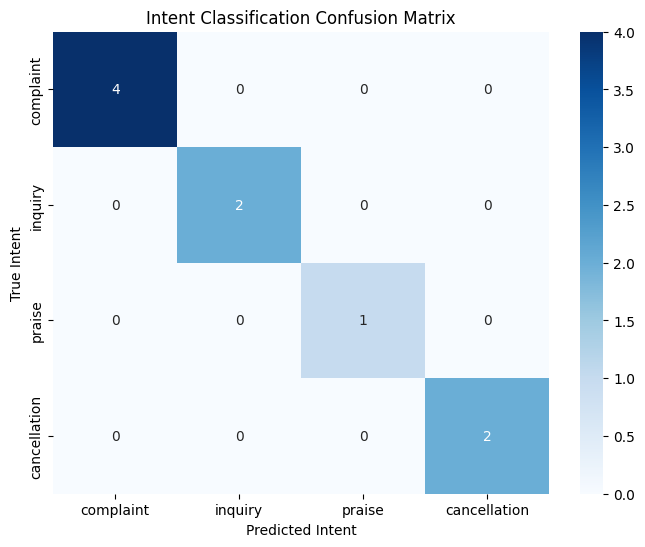

✅ Saved intent confusion matrix to '../figures/intent_confusion_matrix.png'


In [36]:
# Validate intent classification on a ground-truth set to assess model performance.

ground_truth = pd.DataFrame({
    'customer_text': [
        "This service is terrible, fix it!", 
        "How do I change my plan?", 
        "Thanks for the great support!", 
        "I’m canceling my account",
        "Why is this service so bad?",
        "So sick of your shit service!",
        "No you have gone cheap and saved money!",
        "When will my order arrive?",
        "I want to unsubscribe from this service."
    ],
    'true_intent': ['complaint', 'inquiry', 'praise', 'cancellation', 'complaint', 'complaint', 'complaint', 'inquiry', 'cancellation'],
    'sentiment_label': ['NEGATIVE', 'NEUTRAL', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'NEGATIVE']
})
ground_truth['predicted_intent'] = classify_and_explain_batch(
    ground_truth['customer_text'].tolist(), 
    ground_truth['sentiment_label'].tolist(), 
    [1, 0, 0, 1, 1, 1, 1, 0, 1]
)['intent_label']
print("\nValidation Metrics:")
print(classification_report(ground_truth['true_intent'], ground_truth['predicted_intent'], zero_division=0))

# Confusion matrix
cm = confusion_matrix(ground_truth['true_intent'], ground_truth['predicted_intent'], labels=intent_categories)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intent_categories, yticklabels=intent_categories)
plt.title('Intent Classification Confusion Matrix')
plt.xlabel('Predicted Intent')
plt.ylabel('True Intent')
plt.savefig('../figures/intent_confusion_matrix.png')
plt.show()
print("✅ Saved intent confusion matrix to '../figures/intent_confusion_matrix.png'")

## 5. Priority Scoring

In [37]:
# Assign priority scores based on intent, sentiment, and churn risk for call center routing.

def assign_priority(intent, sentiment, churn):
    intent_weights = {'cancellation': 0.8, 'complaint': 0.6, 'inquiry': 0.4, 'praise': 0.2}
    base_score = intent_weights.get(intent, 0.4)
    sentiment_modifier = {'NEGATIVE': 0.2, 'NEUTRAL': 0.0, 'POSITIVE': -0.1}
    score = base_score + sentiment_modifier.get(sentiment, 0.0)
    if churn == 1:
        score += 0.2
    return min(max(score, 0.0), 1.0)

df_sample['priority_score'] = df_sample.apply(
    lambda row: assign_priority(row['intent_label'], row['sentiment_label'], row['churn_label']),
    axis=1
)
print("✅ Priority scores assigned.")
print(df_sample[['customer_text', 'intent_label', 'priority_score', 'intent_explanation']].head().to_string(index=False))

# Merge back to main dataframe
df = df.merge(df_sample[['customer_text', 'intent_label', 'priority_score', 'intent_explanation']], on='customer_text', how='left')

# Save results
df.to_csv('../data/processed/intent_priority_twcs.csv', index=False)
print("✅ Saved dataset to '../data/processed/intent_priority_twcs.csv'")
df_sample[['customer_text', 'intent_label', 'priority_score', 'intent_explanation']].to_csv('../figures/sample_intents.csv', index=False)
print("✅ Saved sample intents to '../figures/sample_intents.csv'")

✅ Priority scores assigned.
                                                                                                                                         customer_text intent_label  priority_score                                                                                  intent_explanation
                                                                               Hmm @AmericanAir 588 at the gate and no  gate agents to meet it @ SJC ?      inquiry             0.3 The tweet is classified as inquiry due to lack of clear cancellation, complaint, or praise markers.
                                                                                                                @AppleSupport iPhone 6S and iOS 11.0.2      inquiry             0.5 The tweet is classified as inquiry due to lack of clear cancellation, complaint, or praise markers.
@116136 always some problem with your apps yet you always want your customers to pay your ridic bills!  So annoying #corpgreed https

## 6. Visualizations


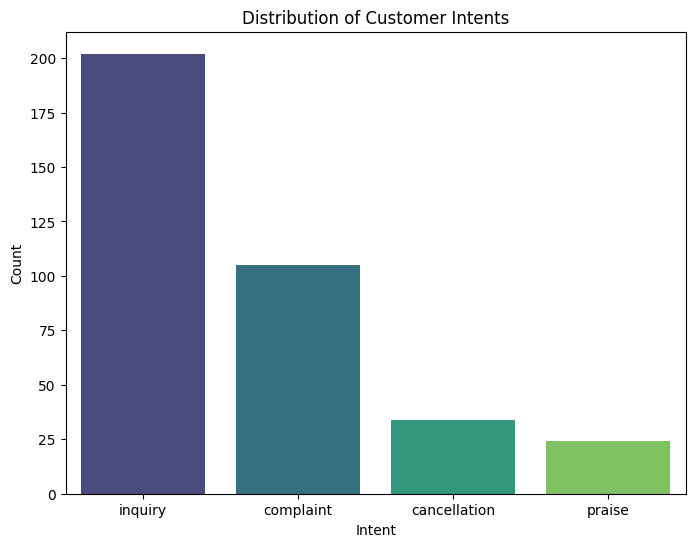

✅ Saved intent distribution to '../figures/intent_distribution.png'


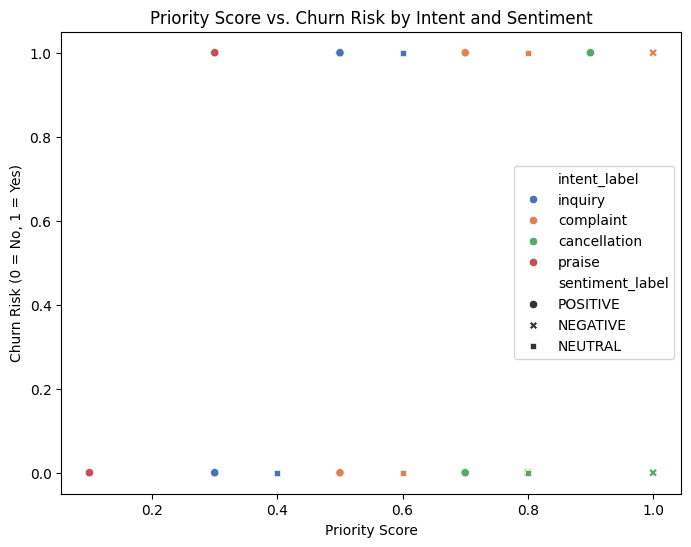

✅ Saved priority vs. churn to '../figures/priority_vs_churn.png'


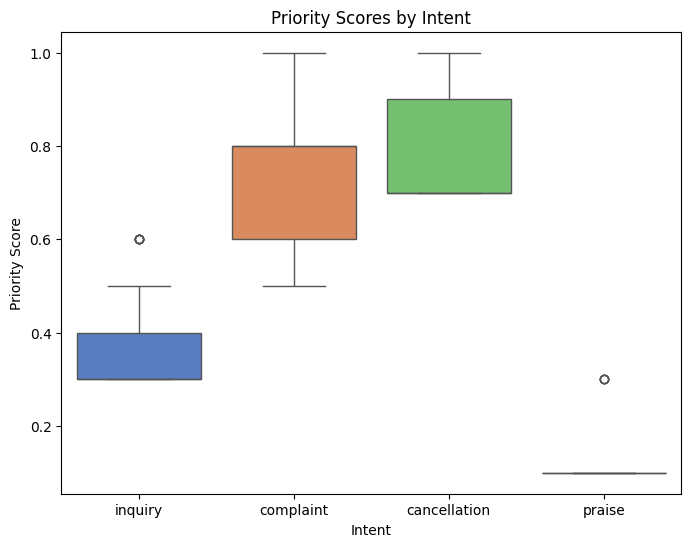

✅ Saved intent vs. priority to '../figures/intent_vs_priority.png'


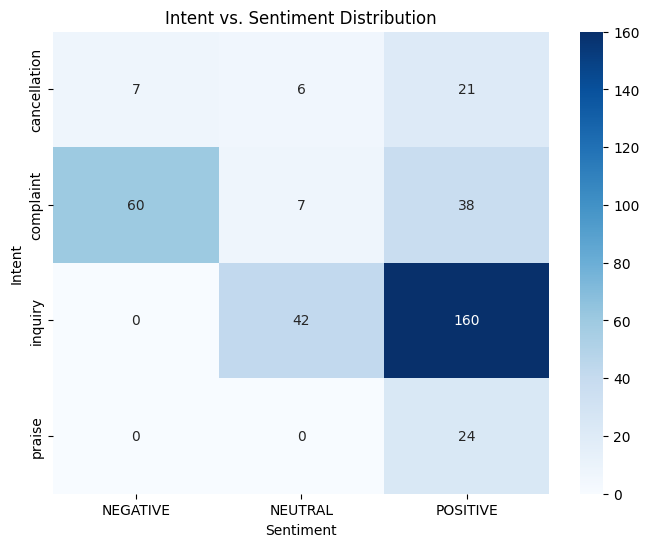

✅ Saved intent vs. sentiment to '../figures/intent_vs_sentiment.png'


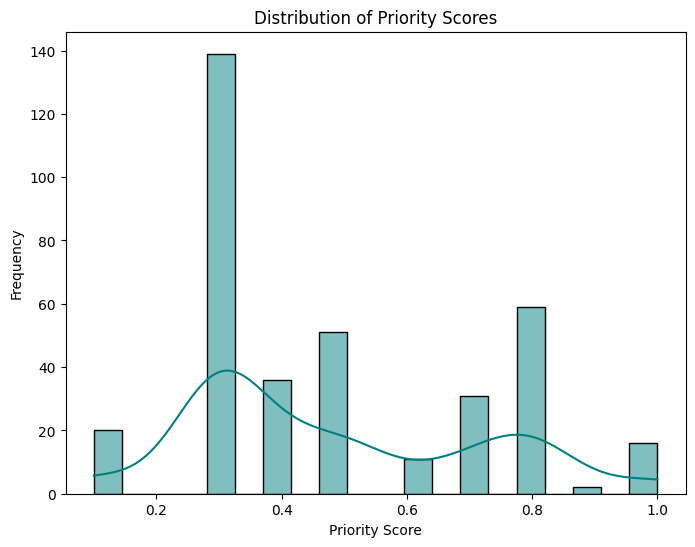

✅ Saved priority distribution to '../figures/priority_distribution.png'


In [38]:
# Generate visualizations to analyze intent distribution, priority scores, and relationships with churn and sentiment.

# Intent Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='intent_label', data=df_sample, palette='viridis')
plt.title('Distribution of Customer Intents')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.savefig('../figures/intent_distribution.png')
plt.show()
print("✅ Saved intent distribution to '../figures/intent_distribution.png'")

# Priority vs. Churn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='priority_score', y='churn_label', data=df_sample, hue='intent_label', style='sentiment_label', palette='deep')
plt.title('Priority Score vs. Churn Risk by Intent and Sentiment')
plt.xlabel('Priority Score')
plt.ylabel('Churn Risk (0 = No, 1 = Yes)')
plt.savefig('../figures/priority_vs_churn.png')
plt.show()
print("✅ Saved priority vs. churn to '../figures/priority_vs_churn.png'")

# Intent vs. Priority
plt.figure(figsize=(8, 6))
sns.boxplot(x='intent_label', y='priority_score', data=df_sample, palette='muted')
plt.title('Priority Scores by Intent')
plt.xlabel('Intent')
plt.ylabel('Priority Score')
plt.savefig('../figures/intent_vs_priority.png')
plt.show()
print("✅ Saved intent vs. priority to '../figures/intent_vs_priority.png'")

# Intent vs. Sentiment Confusion Matrix
cm = pd.crosstab(df_sample['intent_label'], df_sample['sentiment_label'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Intent vs. Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Intent')
plt.savefig('../figures/intent_vs_sentiment.png')
plt.show()
print("✅ Saved intent vs. sentiment to '../figures/intent_vs_sentiment.png'")

# Priority Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_sample['priority_score'], bins=20, kde=True, color='teal')
plt.title('Distribution of Priority Scores')
plt.xlabel('Priority Score')
plt.ylabel('Frequency')
plt.savefig('../figures/priority_distribution.png')
plt.show()
print("✅ Saved priority distribution to '../figures/priority_distribution.png'")